# 分類木 (CART) を実装する

---

## 実装してみる

### 必要なパッケージを読み込む

In [1]:
library(tidyverse)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### 不純度を求める

In [2]:
# 不純度として Gini impurity 用いる
calc_gini <-
  function(data) {
    data %>%
    group_by(y) %>%
    summarise(p = n() / nrow(data)) %>%
    ungroup() %>%
    summarise(impurity = 1 - sum(p^2)) %>%
    .$impurity
  }

In [3]:
# 不純度として information gain を用いる
calc_gain <-
  function(data) {
    data %>%
    group_by(y) %>%
    summarise(p = n() / nrow(data)) %>%
    ungroup() %>%
    summarise(impurity = -1 * sum(p * log(p))) %>%
    .$impurity
  }

### 不純度の減り幅を求める

In [4]:
calc_delta <-
  function(data, calc_impurity) {
    values <- unique(data$x)
    thresholds <- (values[2:length(values)] + values[1:(length(values) - 1)]) / 2
    map_df(thresholds, calc_delta.sub, data, calc_impurity)
  }
calc_delta.sub <-
  function(threshold, data, calc_impurity) {
    left <- data %>% filter(x < threshold)
    right <- data %>% filter(threshold <= x)
    delta <- calc_impurity(data) - (nrow(left) / nrow(data)) * calc_impurity(left) - (nrow(right) / nrow(data)) * calc_impurity(right)
    tibble(threshold = threshold, delta = delta)
  }

### 分類木を作成する

In [5]:
cart <-
  function(data, max_depth, calc_impurity, depth = 0) {
    # 各クラスの割合を求める
    prob <-
      data %>%
      group_by(y) %>%
      summarise(p = n() / nrow(data)) %>%
      ungroup() %>%
      spread(key = y, value = p)
    
    # 深さが最大値に達した場合、これ以上分割しない
    if (depth == max_depth) {
      return(list(prob = prob))
    }
    # 不純度が0の場合、これ以上分割しない
    if (calc_impurity(data) == 0) {
      return(list(prob = prob))
    }
    
    # 不純度の減り幅が最大となる説明変数と閾値を求める
    node <-
      # 説明変数別に、該当する説明変数と目的変数の2変数かなるデータフレームを作成する
      tibble(variable = setdiff(colnames(data), "y")) %>%
      mutate(data = map(variable, ~ tibble(x = data[[.]], y = data$y))) %>%
      # 説明変数別に、不純度を計算する
      mutate(data = map(data, calc_delta, calc_impurity)) %>%
      # ネストしているデータフレームを展開し、フラットにする
      unnest(cols = c(data)) %>%
      # 不純度の減り幅が最大となる説明変数と閾値を取り出す
      filter(delta == max(delta))
    
    # 子ノードを分割する
    left <- data[data[[node[[1, "variable"]]]] < node[[1, "threshold"]], ]
    node.left <- cart(left, max_depth, calc_impurity, depth + 1)
    right <- data[node[[1, "threshold"]] <= data[[node[[1, "variable"]]]], ]
    node.right <- cart(right, max_depth, calc_impurity, depth + 1)
    
    list(self = node, left = node.left, right = node.right, prob = prob)
  }

### 予測する

In [6]:
predict <-
  function(model, data) {
    f <- function(data, model) {
      if (length(names(model)) == 1) {
        return(model$prob)
      }
      if (data[[model$self$variable[1]]] < model$self$threshold[1]) {
        return(f(data, model$left))
      }
      else {
        return(f(data, model$right))
      }
    }
    
    data %>%
      pmap(list) %>%
      map_df(f, model) %>%
      mutate_all(list(replace_na = replace_na)) %>%
      as.matrix()
  }

---

## 実際にモデルを作ってみる

### サンプルデータを生成する

In [7]:
# 再現性を確保するため、乱数のシードを固定する
set.seed(0)

# サンプルデータを生成する
data <-
  bind_rows(
    # 負例を生成する
    tibble(
      y = 0,
      x1 = rnorm(n = 1000, mean = -1, sd = 1),
      x2 = rnorm(n = 1000, mean = -1, sd = 1)
    ),
    # 正例を生成する
    tibble(
      y = 1,
      x1 = rnorm(n = 100, mean = 1, sd = 1),
      x2 = rnorm(n = 100, mean = 1, sd = 1)
    )
  )

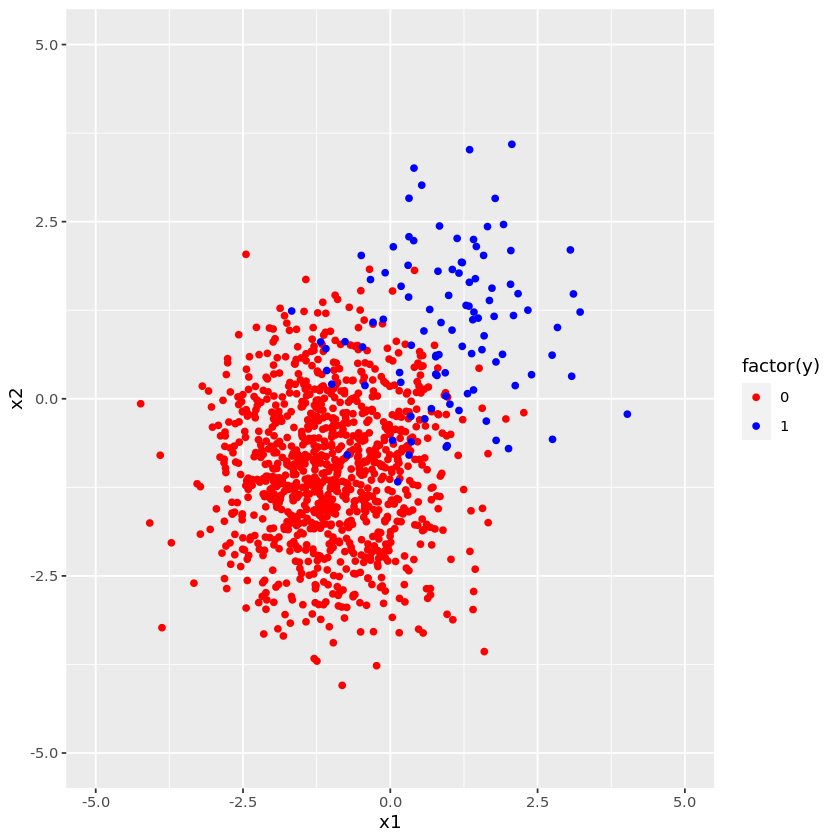

In [8]:
# サンプルデータを可視化する
graph <-
  ggplot(data = data, mapping = aes(x = x1, y = x2, color = factor(y))) +
  geom_point() +
  xlim(-5, 5) +
  ylim(-5, 5) +
  scale_color_manual(values = c("red", "blue"))
plot(graph)

### モデルを生成する (Gini impurity)

In [9]:
model.gini <- cart(data = data, max_depth = 2, calc_impurity = calc_gini)

### モデルを可視化する (Gini impurity)

In [10]:
str(model.gini)

List of 4
 $ self : tibble [1 × 3] (S3: tbl_df/tbl/data.frame)
  ..$ variable : chr "x1"
  ..$ threshold: num 0.926
  ..$ delta    : num 0.0597
 $ left :List of 4
  ..$ self : tibble [3 × 3] (S3: tbl_df/tbl/data.frame)
  .. ..$ variable : chr [1:3] "x2" "x2" "x2"
  .. ..$ threshold: num [1:3] 1.55 1.55 1.54
  .. ..$ delta    : num [1:3] 0.0177 0.0177 0.0177
  ..$ left :List of 1
  .. ..$ prob: tibble [1 × 2] (S3: tbl_df/tbl/data.frame)
  .. .. ..$ 0: num 0.97
  .. .. ..$ 1: num 0.0299
  ..$ right:List of 1
  .. ..$ prob: tibble [1 × 2] (S3: tbl_df/tbl/data.frame)
  .. .. ..$ 0: num 0.235
  .. .. ..$ 1: num 0.765
  ..$ prob : tibble [1 × 2] (S3: tbl_df/tbl/data.frame)
  .. ..$ 0: num 0.958
  .. ..$ 1: num 0.0422
 $ right:List of 4
  ..$ self : tibble [2 × 3] (S3: tbl_df/tbl/data.frame)
  .. ..$ variable : chr [1:2] "x2" "x2"
  .. ..$ threshold: num [1:2] 0.1134 0.0983
  .. ..$ delta    : num [1:2] 0.209 0.209
  ..$ left :List of 1
  .. ..$ prob: tibble [1 × 2] (S3: tbl_df/tbl/data.frame

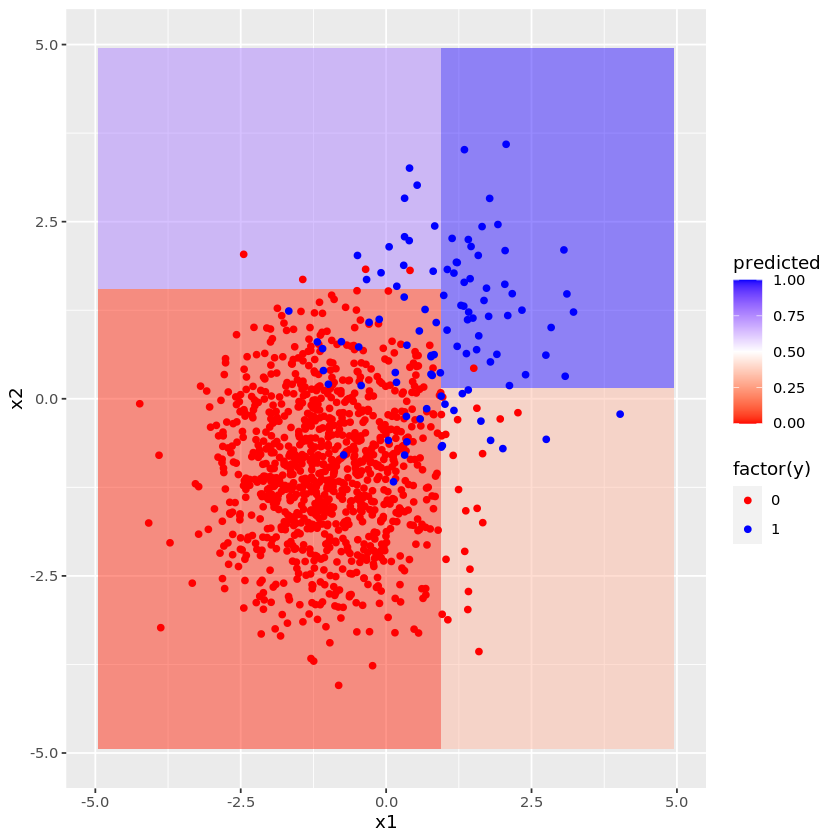

In [11]:
grid <- expand.grid(x1 = seq(-5, 5, 0.1), x2 = seq(-5, 5, 0.1))
grid$predicted <- predict(model.gini, grid)[, 2]
graph <-
  ggplot() +
  geom_tile(data = grid, mapping = aes(x = x1, y = x2, fill = predicted), alpha = 0.5) +
  geom_point(data = data, mapping = aes(x = x1, y = x2, color = factor(y))) +
  xlim(-5, 5) +
  ylim(-5, 5) +
  scale_color_manual(values = c("red", "blue")) +
  scale_fill_gradient2(low = "red", mid = "white", high = "blue", limits = c(0, 1), midpoint = 0.5)
plot(graph)

### モデルを生成する (information gain)

In [12]:
model.gain <- cart(data = data, max_depth = 2, calc_impurity = calc_gain)

### モデルを可視化する (information gain)

In [13]:
str(model.gain)

List of 4
 $ self : tibble [1 × 3] (S3: tbl_df/tbl/data.frame)
  ..$ variable : chr "x1"
  ..$ threshold: num 0.301
  ..$ delta    : num 0.105
 $ left :List of 4
  ..$ self : tibble [1 × 3] (S3: tbl_df/tbl/data.frame)
  .. ..$ variable : chr "x2"
  .. ..$ threshold: num 0.183
  .. ..$ delta    : num 0.0292
  ..$ left :List of 1
  .. ..$ prob: tibble [1 × 2] (S3: tbl_df/tbl/data.frame)
  .. .. ..$ 0: num 0.996
  .. .. ..$ 1: num 0.00377
  ..$ right:List of 1
  .. ..$ prob: tibble [1 × 2] (S3: tbl_df/tbl/data.frame)
  .. .. ..$ 0: num 0.864
  .. .. ..$ 1: num 0.136
  ..$ prob : tibble [1 × 2] (S3: tbl_df/tbl/data.frame)
  .. ..$ 0: num 0.978
  .. ..$ 1: num 0.0217
 $ right:List of 4
  ..$ self : tibble [1 × 3] (S3: tbl_df/tbl/data.frame)
  .. ..$ variable : chr "x2"
  .. ..$ threshold: num 0.505
  .. ..$ delta    : num 0.266
  ..$ left :List of 1
  .. ..$ prob: tibble [1 × 2] (S3: tbl_df/tbl/data.frame)
  .. .. ..$ 0: num 0.803
  .. .. ..$ 1: num 0.197
  ..$ right:List of 1
  .. ..$ prob

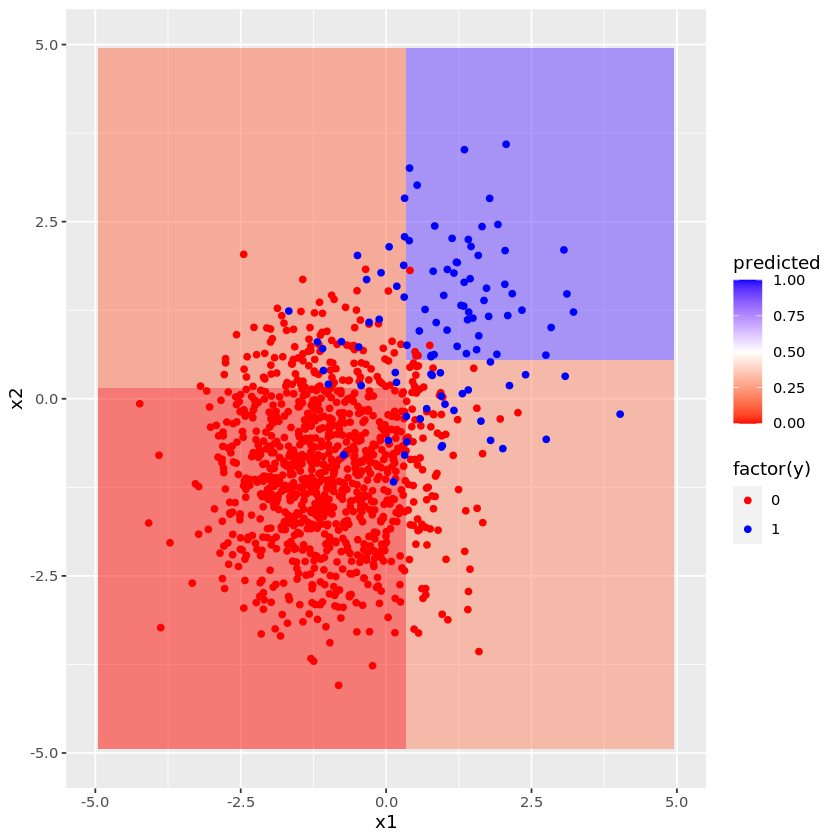

In [14]:
grid <- expand.grid(x1 = seq(-5, 5, 0.1), x2 = seq(-5, 5, 0.1))
grid$predicted <- predict(model.gain, grid)[, 2]
graph <-
  ggplot() +
  geom_tile(data = grid, mapping = aes(x = x1, y = x2, fill = predicted), alpha = 0.5) +
  geom_point(data = data, mapping = aes(x = x1, y = x2, color = factor(y))) +
  xlim(-5, 5) +
  ylim(-5, 5) +
  scale_color_manual(values = c("red", "blue")) +
  scale_fill_gradient2(low = "red", mid = "white", high = "blue", limits = c(0, 1), midpoint = 0.5)
plot(graph)

---

## 参考文献

* [ツリーモデル(木) - Mingzhe Jin’s Home Page](https://www1.doshisha.ac.jp/~mjin/R/Chap_19/19.html)
* [決定木アルゴリズムを実装してみる - Pythonと機械学習](http://darden.hatenablog.com/entry/2016/12/15/222447)
* [Decision tree learning - Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning)

---

## 動作環境

In [15]:
sessionInfo()

R version 3.5.2 (2018-12-20)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 10 (buster)

Matrix products: default
BLAS: /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.8.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.8.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] forcats_0.5.1   stringr_1.4.0   dplyr_1.0.4     purrr_0.3.4    
[5] readr_1.4.0     tidyr_1.1.2     tibble_3.0.6    ggplot2_3.3.3  
[9] tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-5      tidyselect_1.1.0  repr_1.1.3        haven_2.3.1      
 [5] colorspace_2.0-0  vctrs_0.3.6       